In [1]:
import os
import scanpy as sc

work_dir = '/Scottbrowne/members/smd/Projects/SD031/scenicplus/B16_CART'
data_dir = '/Scottbrowne/seq/tmp/devoes/SD031'
tmp_dir =  '/scratch2/devoes/tmp/'

#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

# load cluster annotations
adata = sc.read_h5ad(os.path.join(work_dir, 'RNA/adata_SCA.h5ad'))
scRNA_bc = adata.obs_names
cell_data = adata.obs
cell_data['sample_id'] = 'GSE202543_B16_CART_tumor'
cell_data['leiden'] = cell_data['leiden'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.

del(adata)

In [2]:
# load atac
import pickle
fragments_dict = {"GSE202543_B16_CART_tumor" : os.path.join(data_dir,'GSE202543/B16_CAR_T_D7_Tumor/cellranger-arc_outs/GSE202543_B16_CAR_T_D7_Tumor/outs/atac_fragments.tsv.gz')}
path_to_regions = {'GSE202543_B16_CART_tumor':os.path.join(work_dir, 'ATAC/consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= '/Scottbrowne/members/smd/genomes/mm10/ENCODE_blacklist/mm10-blacklist.v2.bed.gz'
metadata_bc = pickle.load(open(os.path.join(work_dir, 'ATAC/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'ATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

In [3]:
print(f"{len(list(set(bc_passing_filters['GSE202543_B16_CART_tumor']) & set(scRNA_bc)))} cell barcodes pass both scATAC-seq and scRNA-seq based filtering")

12295 cell barcodes pass both scATAC-seq and scRNA-seq based filtering


In [4]:
# create cistopic object

from pycisTopic.cistopic_class import *

key = 'GSE202543_B16_CART_tumor'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key]) & set(scRNA_bc)),
                            n_cpu=1,
                            project=key,
                            split_pattern='-')

cistopic_obj.add_cell_data(cell_data, split_pattern='-')

print(cistopic_obj)

2024-06-01 14:25:42,178 cisTopic     INFO     Reading data for GSE202543_B16_CART_tumor
2024-06-01 14:31:59,788 cisTopic     INFO     metrics provided!
2024-06-01 14:32:17,231 cisTopic     INFO     valid_bc provided, selecting barcodes!
2024-06-01 14:32:35,035 cisTopic     INFO     Counting fragments in regions
2024-06-01 14:37:52,751 cisTopic     INFO     Creating fragment matrix


/home/devoes/miniconda3/envs/SCENICplus_SCA/lib/python3.10/site-packages/pycisTopic/cistopic_class.py:881: PerformanceWarning: The following operation may generate 3930588550 cells in the resulting pandas object.
  counts_df.groupby(["Name", "regionID"], sort=False, observed=True)


2024-06-01 14:40:22,570 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-06-01 14:41:48,766 cisTopic     INFO     Removing blacklisted regions
2024-06-01 14:41:51,316 cisTopic     INFO     Creating CistopicObject
2024-06-01 14:41:56,309 cisTopic     INFO     Done!
Columns ['sample_id'] will be overwritten
CistopicObject from project GSE202543_B16_CART_tumor with n_cells × n_regions = 12295 × 319690


In [5]:
# save cistopic object
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'ATAC/cistopic_obj.pkl'), 'wb'))

In [ ]:
# create models

import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'ATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.cistopic_class import *
models=run_cgs_models(cistopic_obj,
                    n_topics= [2,4,10,16,24,32,40,48,56,64,72,80,96],
                    n_cpu=5,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = os.path.join(tmp_dir, 'ray_spill'))


2024-06-01 15:16:17,747	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


(run_cgs_model pid=27564) 2024-06-01 15:16:20,774 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=27564) 2024-06-01 17:10:44,266 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=27565) 2024-06-01 15:16:21,892 cisTopic     INFO     Running model with 24 topics [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(run_cgs_model pid=27568) 2024-06-01 17:39:37,897 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=27564) 2024-06-01 17:10:44,473 cisTopic     INFO     Running model with 32 topics
(run_cgs_model pid=27568) 2024-06-01 17:39:38,050 cisTopic     INFO     Running model with 40 topics
(run_cgs_model pid=27566) 2024-06-01 18:53:59,076 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=27566) 2024-06-01 18:53:59,226 cisTopic     INFO     Runnin

In [ ]:
# save models so we don't need to re-run

if not os.path.exists(os.path.join(work_dir, 'ATAC/models')):
    os.makedirs(os.path.join(work_dir, 'ATAC/models'))

pickle.dump(models,
            open(os.path.join(work_dir, 'ATAC/models/multiome_models_500_iter_LDA.pkl'), 'wb'))

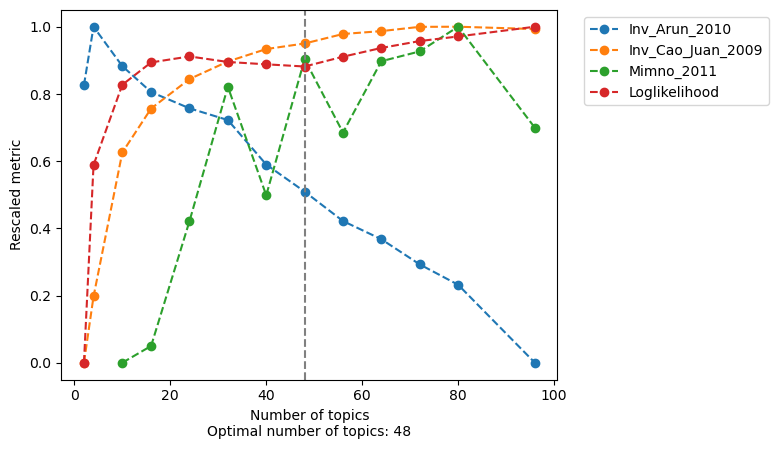

In [13]:
# evaluate models

models = pickle.load(open(os.path.join(work_dir, 'ATAC/models/multiome_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'ATAC/cistopic_obj.pkl'), 'rb'))

from pycisTopic.lda_models import *
model = evaluate_models(models,
                        select_model = 48,
                       #select_model=None, # let model be selected computationally (for which model to return)
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [14]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'ATAC/cistopic_obj_48Topics.pkl'), 'wb'))